In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#cross-validation
from sklearn.model_selection import cross_val_score

#resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#reports
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

In [16]:
#Importing clean data
pickleFile = open('X_dummies.pickle', 'rb')
X = pickle.load(pickleFile)
pickleFile.close()

pickleFile = open('y.pickle', 'rb')
y = pickle.load(pickleFile)
pickleFile.close()

#### Train/Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y,
                              test_size=.2, random_state=42)

#### Feature Importance

In [18]:
forest_selection = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest_selection.fit(X_train, y_train)
importances = forest_selection.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_selection.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

<ipython-input-18-3b6cef20e260>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_selection.fit(X_train, y_train)


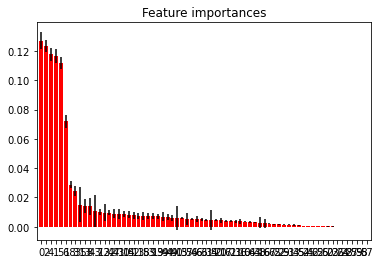

In [19]:
#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
         color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [20]:
#selecting the most important features
number_selected_features = 25
X_train, X_test = X_train.values[:, indices[:number_selected_features]], X_test.values[:, indices[:number_selected_features]]
y_train, y_test = y_train.values, y_test.values

In [21]:
featurenames =X.columns
for i in indices[:25]:
    print(featurenames[i])

geo_level_1_id
geo_level_3_id
age
geo_level_2_id
area_percentage
height_percentage
count_families
count_floors_pre_eq
foundation_type_r
has_superstructure_timber
has_superstructure_mud_mortar_stone
ground_floor_type_v
has_superstructure_adobe_mud
has_superstructure_cement_mortar_brick
land_surface_condition_t
other_floor_type_q
ground_floor_type_f
land_surface_condition_n
has_superstructure_bamboo
position_s
has_superstructure_mud_mortar_brick
roof_type_n
position_t
has_superstructure_stone_flag
has_secondary_use


#### Methods for under comparison

In [21]:
Methods_sampling = [
    (RandomUnderSampler(sampling_strategy='not minority', random_state=42), 'RUS'),
    (RandomOverSampler(sampling_strategy = 'not majority', random_state = 42), 'ROS'),
    (SMOTE(sampling_strategy = 'not majority', random_state = 42, k_neighbors = 1), 'smote_1'),
    (SMOTE(sampling_strategy = 'not majority', random_state = 42, k_neighbors = 5), 'smote_5'), 
]


Methods_learn = [
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=6), 'DT6'),
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=12), 'DT12'),
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=32), 'DT32'),
    (RandomForestClassifier(n_estimators= 50, criterion = 'gini'), 'RF_50'),
    (RandomForestClassifier(n_estimators= 100, criterion = 'gini'), 'RF_100'), 
    (KNeighborsClassifier(n_neighbors = 5), 'KNN_5'), 
    (KNeighborsClassifier(n_neighbors = 15), 'KNN_15'),
    (LogisticRegression(C = 1, max_iter=3000, solver = 'sag', random_state = 42), 'LR'),
    (GradientBoostingClassifier(random_state = 42), 'GB_default'),
    (GradientBoostingClassifier(n_estimators=500, random_state = 42), 'GB_ne500'),
    (GradientBoostingClassifier(n_estimators=500, max_depth=10, random_state = 42), 'GB_ne500md10'),
    (AdaBoostClassifier(), 'AB'),
    (LinearSVC(C = 0.1, random_state = 42, max_iter=10000), 'LSVC_0.1'),
    (LinearSVC(C = 1, random_state = 42, max_iter=10000), 'LSVC_1'),
    (LinearSVC(C = 10, random_state = 42, max_iter=10000), 'LSVC_10'),
    (GaussianNB(), 'Gaussian'),
]

#### Metrics

In [22]:
dict_results = {}

recalls = []
precisions = []
f1 = []
methods = []

#### Running the algorithms with cross-validation

In [27]:
for sampler, samplerName in Methods_sampling:
    for model, modelName in Methods_learn:
        print(samplerName, modelName)
        Ks = StratifiedKFold(n_splits = 10, random_state = 42, shuffle= True) # Create Object
        Ks.get_n_splits(X_train, y_train) # Preparar para experiment
        
        recalls_fold = []
        precisions_fold = []
        f1_fold = []

        
        for train_idx, val_idx in Ks.split(X_train, y_train):
            xTrain_fold, yTrain_fold = X_train[train_idx, :], y_train[train_idx] 
            xVal_fold, yVal_fold = X_train[val_idx, :], y_train[val_idx] 

    
            xTrain_resample, yTrain_resample = sampler.fit_sample(xTrain_fold, yTrain_fold)
                                                                  
            model.fit(xTrain_resample, yTrain_resample)
                                                                  
            yPred = model.predict(xVal_fold)

            recalls_fold.append([recall_score(yVal_fold,yPred, average = None)])
            precisions_fold.append([precision_score(yVal_fold,yPred, average = None)])
            f1_fold.append([f1_score(yVal_fold,yPred, average = None)])

            methods.append(samplerName+"-"+modelName)
        recalls_fold = np.vstack(recalls_fold)
        precisions_fold = np.vstack(precisions_fold)
        f1_fold = np.vstack(f1_fold)
        
        recalls.append(recalls_fold.mean(axis = 0))
        precisions.append(precisions_fold.mean(axis = 0))
        f1.append(f1_fold.mean(axis = 0))

RUS DT6
RUS DT12
RUS DT32
RUS RF_50
RUS RF_100
RUS KNN_5
RUS KNN_15
RUS LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

RUS GB_default
RUS GB_ne500
RUS GB_ne500md10
RUS AB
RUS LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS Gaussian
ROS DT6
ROS DT12
ROS DT32
ROS RF_50
ROS RF_100
ROS KNN_5
ROS KNN_15
ROS LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

ROS GB_default
ROS GB_ne500
ROS GB_ne500md10
ROS AB
ROS LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS Gaussian
smote_1 DT6
smote_1 DT12
smote_1 DT32
smote_1 RF_50
smote_1 RF_100
smote_1 KNN_5
smote_1 KNN_15
smote_1 LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

smote_1 GB_default
smote_1 GB_ne500
smote_1 GB_ne500md10
smote_1 AB
smote_1 LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 Gaussian
smote_5 DT6
smote_5 DT12
smote_5 DT32
smote_5 RF_50
smote_5 RF_100
smote_5 KNN_5
smote_5 KNN_15
smote_5 LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

smote_5 GB_default
smote_5 GB_ne500
smote_5 GB_ne500md10
smote_5 AB
smote_5 LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_5 LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/li

smote_5 LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_5 Gaussian


### Organizing scores for comparison

In [ ]:
recalls = np.vstack(recalls)
precisions = np.vstack(precisions)
f1 = np.vstack(f1)

recalls = pd.DataFrame(recalls.T, columns = methods)
precisions = pd.DataFrame(precisions.T, columns = methods)
f1 = pd.DataFrame(f1.T, columns = methods)

recalls.to_excel('recalls_multiclass.xlsx')
precisions.to_excel('precisions_multiclass.xlsx')
f1.to_excel('f1_multiclass.xlsx')

In [9]:
pd.set_option('display.max_columns', 500)

#### Recalls for classes 1, 2, and 3

In [10]:
recalls = pd.read_excel('/Users/lauraurdapilleta/OneDrive/Metis/onl20_ds4/curriculum/project-03/my-project-03/EDA/My Repo/recalls_multiclass.xlsx')
recalls

,Unnamed: 0,RUS-DT6,RUS-DT12,RUS-DT32,RUS-RF_50,RUS-RF_100,RUS-KNN_5,ROS-DT6,ROS-DT12,ROS-DT32,ROS-RF_50,ROS-RF_100,ROS-KNN_5,smote_1-DT6,smote_1-DT12,smote_1-DT32,smote_1-RF_50,smote_1-RF_100,smote_1-KNN_5,smote_5-DT6,smote_5-DT12,smote_5-DT32,smote_5-RF_50,smote_5-RF_100,smote_5-KNN_5
0,0,0.730204,0.721164,0.689603,0.779935,0.770873,0.680962,0.736295,0.671451,0.424151,0.498485,0.493751,0.628196,0.629939,0.569367,0.466489,0.502383,0.498925,0.606581,0.592728,0.552541,0.481628,0.536543,0.529200,0.610474
1,1,0.442802,0.449102,0.457375,0.487474,0.483737,0.389267,0.449687,0.518457,0.672551,0.744179,0.753334,0.514503,0.538672,0.595064,0.627509,0.723597,0.722427,0.535011,0.530322,0.615132,0.618354,0.698258,0.704849,0.540357
2,2,0.709451,0.675712,0.606247,0.670731,0.676330,0.374954,0.711068,0.709821,0.568278,0.582223,0.589567,0.596162,0.715175,0.676083,0.580103,0.602635,0.603758,0.597411,0.732108,0.667623,0.581723,0.606996,0.609235,0.577742


#### Precisions for classes 1, 2, and 3

In [13]:
precisions = pd.read_excel('/Users/lauraurdapilleta/OneDrive/Metis/onl20_ds4/curriculum/project-03/my-project-03/EDA/My Repo/precisions_multiclass.xlsx')
precisions

,Unnamed: 0,RUS-DT6,RUS-DT12,RUS-DT32,RUS-RF_50,RUS-RF_100,RUS-KNN_5,ROS-DT6,ROS-DT12,ROS-DT32,ROS-RF_50,ROS-RF_100,ROS-KNN_5,smote_1-DT6,smote_1-DT12,smote_1-DT32,smote_1-RF_50,smote_1-RF_100,smote_1-KNN_5,smote_5-DT6,smote_5-DT12,smote_5-DT32,smote_5-RF_50,smote_5-RF_100,smote_5-KNN_5
0,0,0.322089,0.315535,0.291872,0.356216,0.358441,0.180787,0.321197,0.358338,0.423805,0.533444,0.536956,0.310331,0.403061,0.402957,0.380569,0.522836,0.524958,0.310209,0.420313,0.417262,0.369553,0.497848,0.498470,0.292020
1,1,0.722639,0.704220,0.671439,0.722401,0.720881,0.627408,0.727285,0.732759,0.673463,0.700556,0.704954,0.698541,0.726922,0.718406,0.677161,0.705682,0.704846,0.703018,0.731048,0.715716,0.679554,0.706742,0.708185,0.703904
2,2,0.552740,0.543476,0.527740,0.554702,0.551311,0.442345,0.561200,0.570410,0.567328,0.638273,0.650905,0.517170,0.560722,0.577040,0.548230,0.622917,0.621590,0.528270,0.543470,0.583337,0.546134,0.608735,0.615905,0.534987


#### F1s for classes 1, 2, and 3

In [14]:
f1 = pd.read_excel('/Users/lauraurdapilleta/OneDrive/Metis/onl20_ds4/curriculum/project-03/my-project-03/EDA/My Repo/f1_multiclass.xlsx')
f1

,Unnamed: 0,RUS-DT6,RUS-DT12,RUS-DT32,RUS-RF_50,RUS-RF_100,RUS-KNN_5,ROS-DT6,ROS-DT12,ROS-DT32,ROS-RF_50,ROS-RF_100,ROS-KNN_5,smote_1-DT6,smote_1-DT12,smote_1-DT32,smote_1-RF_50,smote_1-RF_100,smote_1-KNN_5,smote_5-DT6,smote_5-DT12,smote_5-DT32,smote_5-RF_50,smote_5-RF_100,smote_5-KNN_5
0,0,0.444986,0.438680,0.410055,0.488926,0.489263,0.285673,0.445141,0.467010,0.423664,0.514959,0.514142,0.415361,0.490845,0.471590,0.418868,0.511879,0.511234,0.410410,0.491553,0.475166,0.417890,0.515966,0.512920,0.394922
1,1,0.548730,0.548279,0.543975,0.581972,0.578836,0.480275,0.554937,0.607027,0.672972,0.721673,0.728309,0.592492,0.618641,0.650802,0.651338,0.714501,0.713508,0.607573,0.614464,0.661412,0.647439,0.702432,0.706472,0.611335
2,2,0.620685,0.602123,0.564189,0.607086,0.607284,0.405742,0.627241,0.632388,0.567771,0.608795,0.618581,0.553801,0.628483,0.622490,0.563500,0.612499,0.612447,0.560618,0.623658,0.622422,0.563244,0.607733,0.612434,0.555434


All combinations were compared. Decision tree with random over sampler gave us a better recall for class number 3 (complete destruction). The model that offered the best recall for class 3 was chosen because it is critical to identify as much buildings at risk as possible. 

### Selected Model
Getting final scores and confusion matrix on test set with the selected algorithm

                   pre       rec       spe        f1       geo       iba       sup

          1       0.36      0.79      0.85      0.49      0.82      0.66       579
          2       0.73      0.46      0.77      0.57      0.60      0.35      3413
          3       0.56      0.71      0.71      0.62      0.71      0.51      2008

avg / total       0.64      0.58      0.76      0.58      0.66      0.43      6000



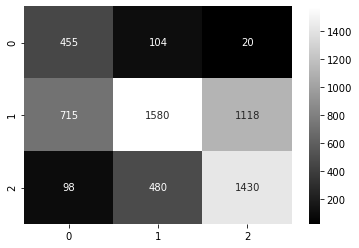

In [22]:
selected_model = tree.DecisionTreeClassifier(random_state = 42, max_depth=6)
selected_sampler = RandomOverSampler(sampling_strategy = 'not majority', random_state = 42)

xTrain_resample, yTrain_resample = selected_sampler.fit_sample(X_train, y_train)
selected_model.fit(xTrain_resample, yTrain_resample)
yPred = selected_model.predict(X_test)


recalls_test = recall_score(y_test,yPred, average = None)
precisions_test = precision_score(y_test,yPred, average = None)
f1_test = f1_score(y_test,yPred, average = None)

plt.figure()
confusion_m = confusion_matrix(y_test,yPred)
#sns.heatmap(confusion_m/confusion_m.sum()*100, annot=True)
sns.heatmap(confusion_m, annot=True, fmt="d", cmap="gray")

print(classification_report_imbalanced(y_test,yPred))

For future work, we will implement a tree ensemble. 